# **5) Model 3**

In [6]:
import os
import csv
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lit, pandas_udf
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Preprocessing for #3:

In [3]:
# reading in merged df
merged_df = pd.read_csv('wesad_merged_df.csv')

# Removing Features:
----
* overfitting is present : when removing the features with 0.0 importance
* Test accuracy the same when removing features with 0.003 and less
* Test Acuracy best when removing features <= 0.0023:

  
      - 'dominant_right'
      - 'coffee_last_hour'
      - 'smoked_last_hour'

* Test Accuracy gets worse once we remove 'dominant_left'

### Random Forest: Sensor Data + Survey Data (Hypertuning)

In [5]:
# less import. feature
less_important_features = feat_imp_df[feat_imp_df['importance'] <= 0.00]['feature'].tolist()

print(less_important_features)

# drop them
X_train_reduced = X_train.drop(columns=less_important_features)
X_test_reduced = X_test.drop(columns=less_important_features)

# model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=23,           
    min_samples_leaf=2,    
    random_state=42
)
# retrain
rf.fit(X_train_reduced, y_train)
print('Train accuracy for set with removed features:', rf.score(X_train_reduced, y_train))
print('Test accuracy for set with removed features:', rf.score(X_test_reduced, y_test))

['coffee_last_hour', 'smoked_last_hour']
Train accuracy for set with removed features: 0.9186449220112944
Test accuracy for set with removed features: 0.7734415383024915


### Post-model analysis

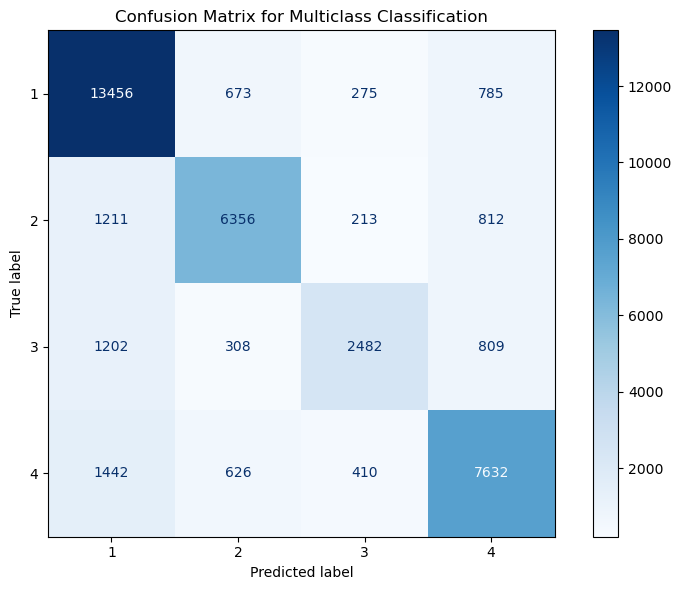

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# pred
y_pred = rf.predict(X_test_reduced)

# conf matrix
cm = confusion_matrix(y_test, y_pred)

class_names = rf.classes_

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap='Blues')
ax.set_title('Confusion Matrix for Multiclass Classification')
plt.tight_layout()
plt.show()

# Results
----

**Class Confusion Analysis**

*Class 1*: 13,456/15,189 correct (**88.6%**)

*Class 4*: 7,632/10,110 correct (**75.5%**)

*Class 2*: 6,356/8,592 correct (**74.0%**)

*Class 3*: 2,482/4,801 correct (**51.7%**) **lowest score**

* **Class 3** is the most confused label, having only about half of the true class 3 correctly predicted
* **Class 1** is the least confused, having only 11.4% of its labels misclassified. 

**Model Performance Analysis**

The overall accuracy of the multiclass classifier is approximately **77.3%** (29,926 correctly classified out of 38,692 total samples). The confusion matrix (Figure X) reveals that the model performs best on class 1 (88.6% correct) and worst on class 3 (51.7% correct), with class 3 being most frequently misclassified as class 1. This suggests possible feature similarity or class imbalance issues, particularly affecting class 3. 

To improve performance, especially for class 3, we recommend collecting more data for underrepresented classes, engineering more discriminative features, and considering model tuning or advanced resampling techniques.

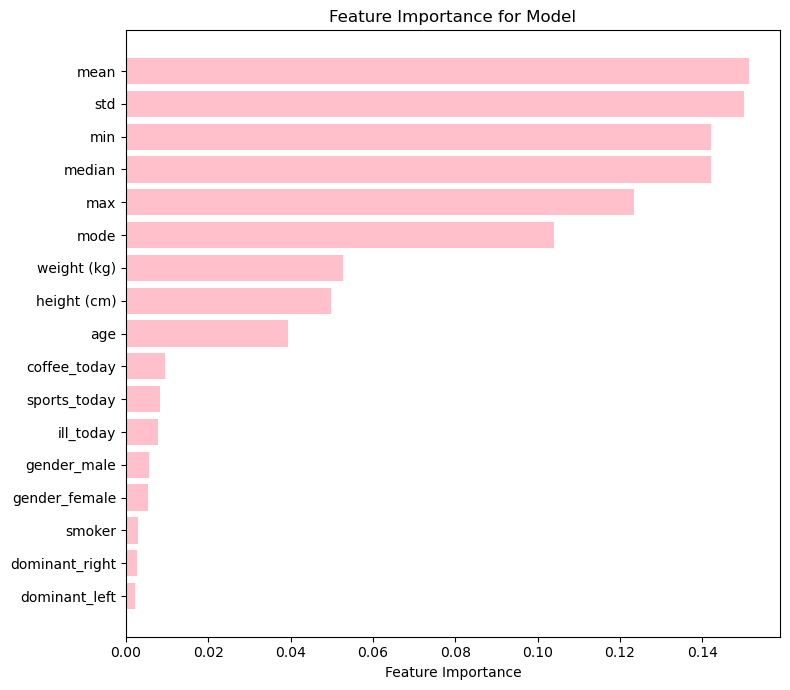

In [6]:
import matplotlib.pyplot as plt
import numpy as np


importances = rf.feature_importances_
feature_names = X_train_reduced.columns

# sort
indices = np.argsort(importances)
sorted_feature_names = feature_names[indices]
sorted_importances = importances[indices]

## graph
plt.figure(figsize=(8, 7))
plt.barh(sorted_feature_names, sorted_importances, color='pink')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Model")
plt.tight_layout()
plt.show()

# For Report: **Label Prediction Based on Feature Probability**
---
## **Label 1**
----

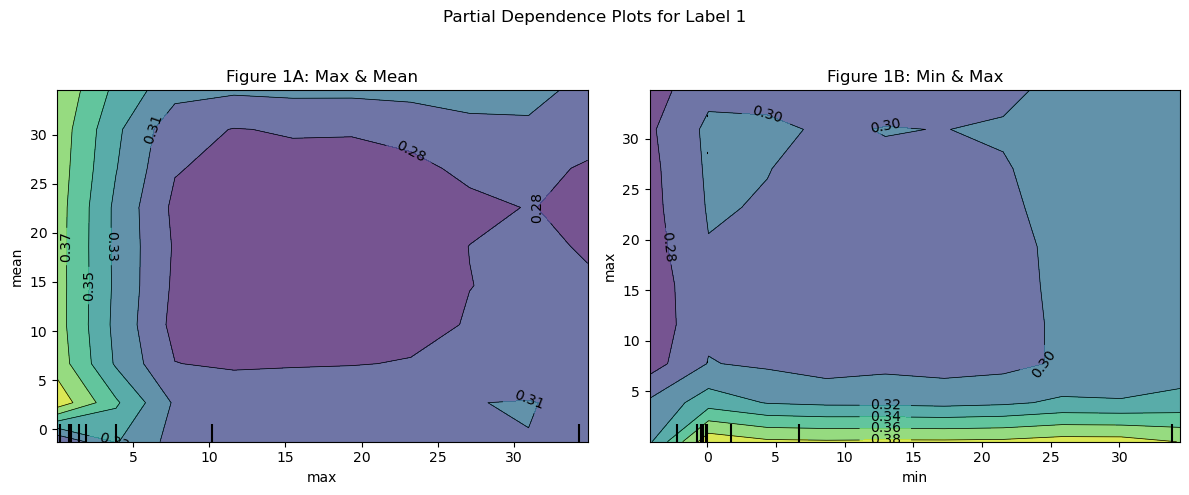

In [28]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

feature_pairs = [
    ('max', 'mean'),  # Max & Mean (Figure A)
    ('min', 'max'),   # Min & Max (Figure B)
]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

titles = ["Figure 1A", "Figure 1B"]

for i, features in enumerate(feature_pairs):
    disp = PartialDependenceDisplay.from_estimator(
        rf,
        X_test_reduced,
        features=[features],
        target=1,  # 1 = label 1 (second class)
        kind='average',
        grid_resolution=10,
        ax=axs[i]
    )
    axs[i].set_title(f"{titles[i]}: {features[0].capitalize()} & {features[1].capitalize()}")

plt.suptitle("Partial Dependence Plots for Label 1")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## **Label 2**
----

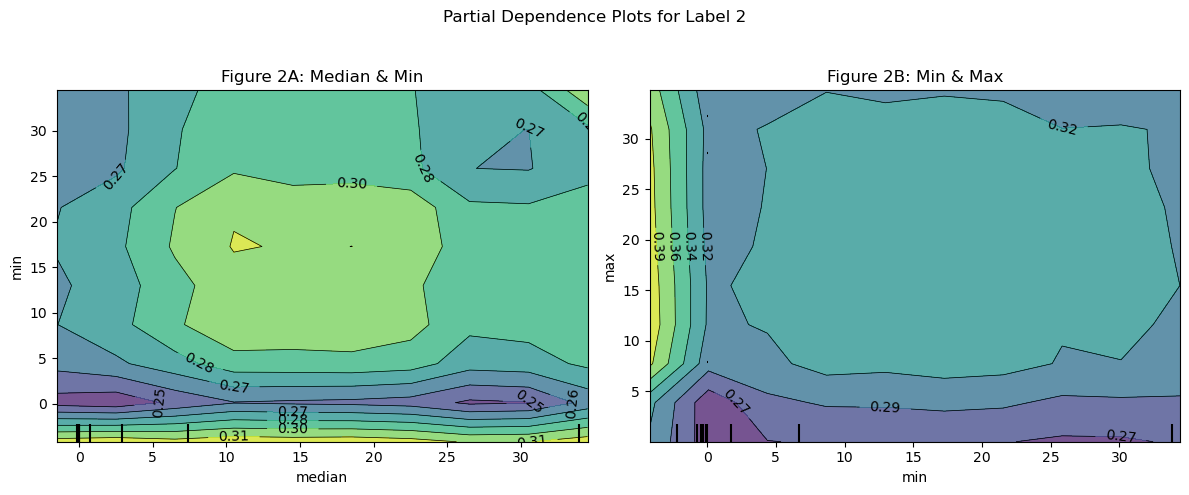

In [7]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# List of feature pairs to plot for label 2
feature_pairs = [
    ('median', 'min'), 
    ('min', 'max'),  
]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

titles = ["Figure 2A", "Figure 2B"]

for i, features in enumerate(feature_pairs):
    disp = PartialDependenceDisplay.from_estimator(
        rf,                      # Your trained RandomForestClassifier
        X_test_reduced,          # Test data with same columns as training
        features=[features],     # Must be a list of tuples
        target=2,                # 2 = label 2 (third class)
        kind='average',
        grid_resolution=10,
        ax=axs[i]
    )
    axs[i].set_title(f"{titles[i]}: {features[0].capitalize()} & {features[1].capitalize()}")

plt.suptitle("Partial Dependence Plots for Label 2")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# **Label 3**
---

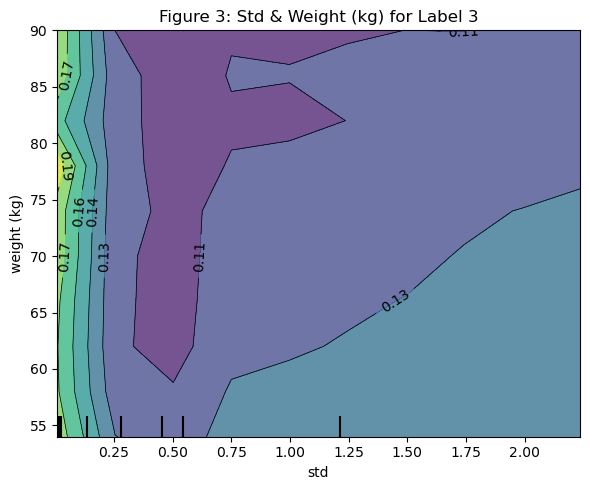

In [30]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 5))

PartialDependenceDisplay.from_estimator(
    rf,
    X_test_reduced,
    features=[('std', 'weight (kg)')],
    target=3,  # label 3
    kind='average',
    grid_resolution=10,
    ax=ax
)
ax.set_title("Figure 3: Std & Weight (kg) for Label 3")
plt.tight_layout()
plt.show()

## **Label 4**
----

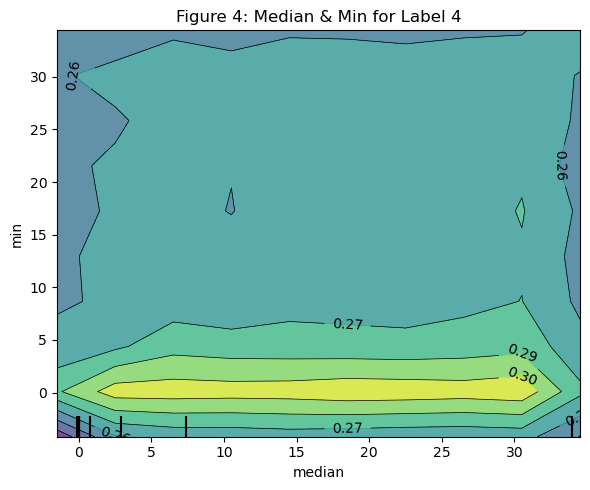

In [31]:
fig, ax = plt.subplots(figsize=(6, 5))

PartialDependenceDisplay.from_estimator(
    rf,
    X_test_reduced,
    features=[('median', 'min')],
    target=4,
    kind='average',
    grid_resolution=10,
    ax=ax
)
ax.set_title("Figure 4: Median & Min for Label 4")
plt.tight_layout()
plt.show()

# Result Figures
----
# Min & Max Features
----
* This is a 2D partial dependence plot showing how the model's predicted probability fro a specific label varies as min and max features change, while averaging all the other features.
* x-axis: represents the values of the min feature
* y-axis represents the values of the max feature
* The contours and colored regions represent tje predicted probability of a specific class, given the values of min and max
* each contour line is annotated witht he probability value
* Brighter regions indicate higher predicted probability for that class
* Darker regions indicate lower predicted probability.
----

Figure 1A presents a 2D partial dependence plot for the features min and max, illustrating their joint effect on the model's predicted probability for class Y. 

----
## Label 1

* The 2D partial dependence plot for class 1 (see Figure X) demonstrates that the model assigns the highest predicted probability to class 1 when both the min and max feature values are low. Specifically, the bottom left region of the plot (low min, low max) shows probability values as high as 0.38. As either min or max increases, the predicted probability for class 1 decreases, with most of the plot exhibiting lower probabilities (around 0.30 or less). This indicates that class 1 is favored by the model when both features are at their minimum values.
----
## Label 2

* For class 2 (see Figure Y), the 2D partial dependence plot reveals a slightly different pattern. The highest probabilities (up to 0.39) occur when min is low and max is moderate to high, especially along the left side of the plot. In contrast, when both min and max are low, the predicted probability for class 2 is lower (as low as 0.27). This suggests that the model is more likely to predict class 2 when the min feature is low, but the max feature is higher, distinguishing it from class 1.

# Median & Min
----
## Class 2
----
* Prediction for label 2 is highest when median and min are both moderate values
* The model predicts class 2 more when both median and min are in the mid-range (central yellow region, probabilities up to 0.31)

# Mode vs. Max
----

In [15]:
for idx, label in enumerate(rf.classes_):
    print(f"Index {idx}: Label {label}")

Index 0: Label 1
Index 1: Label 2
Index 2: Label 3
Index 3: Label 4


# Median & Min
----
## Label 4

* Median and min are somewhat meaningful for predicting label 4. The probabilities arent that high which is the reason why it's only somewhat helpful in predicting this label.

* The model is more likely to predict label 4 when min is low, suggesting that this 

# std & weight (kg)
----
## label 3
----
* After systematically evaluating various feature pairs to identify regions of high predicted probability for label 3, most combinations showed no meaningful separation; the classifier’s output was uniformly low across the feature space.

However, the pair std (standard deviation) and weight (kg) showed a modestly more promising pattern compared to other pairs. As seen in Figure X (referring to your contour plot), the predicted probability for label 3 increases slightly in regions where the standard deviation is very low (std ≲ 0.25), largely independent of weight. The probability in this region reaches up to approximately 0.17–0.18, while elsewhere it remains at or below 0.13.

Despite this localized increase, the model’s confidence remains relatively low overall for label 3. No strong or sharply defined region emerges for this label, suggesting that label 3 is inherently difficult to separate using the available features. The std & weight (kg) pair provides the best separation observed, but the effect is marginal.

Summary:

Most feature pairs (including those involving central tendency, spread, and demographic/binary variables) do not meaningfully predict label 3.
The std & weight (kg) pair shows a small region of increased predicted probability for low std values, but the classifier still lacks strong confidence for label 3 overall.

----



# Max & Mean
----
**Label 1**
---

* Label 1 is most likely when both the max and mean values are low.

* For label 1, the combination of low max and low mean values is associated with higher predicted probability, indicating that these features are informative for this class (see Figure X).

# **Results**
---
To interpret and justify the classification results, we examined the predicted class probabilities as a function of key feature pairs. This allowed to to identify which features/feature combinations were most influential in predicting each label

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Classification Report:\n', cr)
print('Confusion Matrix:\n', cm)

Classification Report:
               precision    recall  f1-score   support

           1       0.78      0.89      0.83     15189
           2       0.79      0.74      0.76      8592
           3       0.74      0.51      0.61      4801
           4       0.76      0.76      0.76     10110

    accuracy                           0.77     38692
   macro avg       0.77      0.72      0.74     38692
weighted avg       0.77      0.77      0.77     38692

Confusion Matrix:
 [[13473   681   265   770]
 [ 1231  6326   215   820]
 [ 1228   315  2470   788]
 [ 1446   641   381  7642]]


# Random Forest (OG)

In [37]:
X = merged_df.drop(columns=['subject', 'modality', 'label'])
y = merged_df['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

print('Training Accuracy:', accuracy_score(y_train, y_train_pred))
print('Test Accuracy:', accuracy_score(y_test,y_pred))

# pred
y_pred = rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Training Accuracy: 0.9999935386325162
Test Accuracy: 0.773906750749509
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.87      0.83     15189
           2       0.78      0.75      0.76      8592
           3       0.69      0.55      0.61      4801
           4       0.76      0.76      0.76     10110

    accuracy                           0.77     38692
   macro avg       0.76      0.73      0.74     38692
weighted avg       0.77      0.77      0.77     38692

Confusion Matrix:
[[13179   747   410   853]
 [ 1115  6420   273   784]
 [ 1023   351  2645   782]
 [ 1236   675   499  7700]]


# Results
----
* **Overall Accuracy (Test)**: 77%
* **Training Accuracy**: 0.9999% -------> **Overfitting**
* **Class 1 and 4**: Model does better
* **Class 3**: Model struggles (lower recall and f1-score)
* The **Classes are unbalanced**, there are more samples of class 1 and 4, with class 3 having the fewest, and this could be affecting the model's performance. 



----
* F1-Score: higher = better; = high precision and high recall
* Classes are unbalanced: better to look at F1-scores

* **Macro F1-Score**: unweighted mean of F1-scores for all classes
  
  - each class contributes equally, regardless of how many samples in each class
    

* When classes are unbalanced, Accuracy can be misleading

# HyperTuning Results
----
* All the other options that were tested

In [35]:
from pyspark.sql import SparkSession 
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType

sc = SparkSession.builder.getOrCreate()

results = [
    {'max_depth': 22, 'n_estimators': 70, 'min_samples_leaf': 1, 'train_acc': 0.9331, 'test_acc': 0.7685},
    {'max_depth': 23, 'n_estimators': 70, 'min_samples_leaf': 1, 'train_acc': 0.9519, 'test_acc': 0.7710},
    {'max_depth': 24, 'n_estimators': 70, 'min_samples_leaf': 1, 'train_acc': 0.9612, 'test_acc': 0.7715},
    {'max_depth': 25, 'n_estimators': 70, 'min_samples_leaf': 1, 'train_acc': 0.9725, 'test_acc': 0.7726},
    {'max_depth': 21, 'n_estimators': 70, 'min_samples_leaf': 1, 'train_acc': 0.9150, 'test_acc': 0.7660},
    {'max_depth': 23, 'n_estimators': 80, 'min_samples_leaf': 1, 'train_acc': 0.9522, 'test_acc': 0.7715},
    {'max_depth': 23, 'n_estimators': 90, 'min_samples_leaf': 1, 'train_acc': 0.9531, 'test_acc': 0.7717},
    {'max_depth': 23, 'n_estimators': 95, 'min_samples_leaf': 1, 'train_acc': 0.9538, 'test_acc': 0.7717},
    {'max_depth': 23, 'n_estimators': 100, 'min_samples_leaf': 1, 'train_acc': 0.9536, 'test_acc': 0.7721},
    {'max_depth': 23, 'n_estimators': 100, 'min_samples_leaf': 2, 'train_acc': 0.9124, 'test_acc': 0.7731},
    {'max_depth': 23, 'n_estimators': 100, 'min_samples_leaf': 3, 'train_acc': 0.8872, 'test_acc': 0.7720},
    {'max_depth': 23, 'n_estimators': 100, 'min_samples_leaf': 4, 'train_acc': 0.8644, 'test_acc': 0.7702}
]

schema = StructType([
    StructField('max_depth', IntegerType(),True),
    StructField('n_estimators', IntegerType(),True),
    StructField('min_samples_leaf', IntegerType(),True),
    StructField('train_acc', FloatType(),True),
    StructField('test_acc', FloatType(),True)])

df = sc.createDataFrame(results, schema=schema)

df.show(truncate=False)




    

+---------+------------+----------------+---------+--------+
|max_depth|n_estimators|min_samples_leaf|train_acc|test_acc|
+---------+------------+----------------+---------+--------+
|22       |70          |1               |0.9331   |0.7685  |
|23       |70          |1               |0.9519   |0.771   |
|24       |70          |1               |0.9612   |0.7715  |
|25       |70          |1               |0.9725   |0.7726  |
|21       |70          |1               |0.915    |0.766   |
|23       |80          |1               |0.9522   |0.7715  |
|23       |90          |1               |0.9531   |0.7717  |
|23       |95          |1               |0.9538   |0.7717  |
|23       |100         |1               |0.9536   |0.7721  |
|23       |100         |2               |0.9124   |0.7731  |
|23       |100         |3               |0.8872   |0.772   |
|23       |100         |4               |0.8644   |0.7702  |
+---------+------------+----------------+---------+--------+

